In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import shap
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay
)


C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv("Tables/bnpl_train.csv")
test_df = pd.read_csv("Tables/bnpl_test.csv")
val_df = pd.read_csv("Tables/bnpl_val.csv")
target_col = "default_flag"

In [3]:
print(train_df.shape, test_df.shape, val_df.shape)
print(train_df.head(), test_df.head(), val_df.head())
print("Train nulls in target:", train_df["default_flag"].isna().sum())
print("Train class distribution:\n", train_df["default_flag"].value_counts(normalize=True))

(595, 14) (199, 14) (199, 14)
   external_repayment_loans  credit_card_interest_incidence  default_flag  \
0                         1                               0             0   
1                         0                               0             0   
2                         0                               0             0   
3                         0                               1             0   
4                         1                               1             0   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buyi

In [4]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())



X_train shape: (595, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         1                               0   
1                         0                               0   
2                         0                               0   
3                         0                               1   
4                         1                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buying_score  \
0                  -1.500097               -0.528311   
1                  -1

In [5]:
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())

X_test shape: (199, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         0                               0   
1                         0                               1   
2                         1                               0   
3                         0                               0   
4                         0                               0   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0              0.180572               -0.890977                  0.005600   
1             -1.413380                1.594809                  1.643651   
2              1.546817                0.174360                 -1.670546   
3             -1.413380               -0.180752                 -1.327698   
4             -0.047135                0.529472                  1.567463   

   payment_delinquency_count  impulsive_buying_score  \
0                   1.462180                0.504892   
1                  -0.

In [6]:
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_val shape: (199, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         0                               1   
1                         0                               0   
2                         0                               0   
3                         1                               0   
4                         0                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.502550                1.239697                  0.272259   
1              0.408279               -0.535864                 -1.670546   
2              0.635987               -0.890977                  0.043694   
3             -0.730258                0.884585                 -0.108683   
4              0.635987                0.529472                 -0.337248   

   payment_delinquency_count  impulsive_buying_score  \
0                  -0.907642                0.160491   
1                   1.4

In [7]:
# 4. Peek at feature names and target distribution
print("Features:", X_train.columns.tolist())
print("Train target balance:\n", y_train.value_counts(normalize=True))

Features: ['external_repayment_loans', 'credit_card_interest_incidence', 'bnpl_usage_frequency', 'financial_stress_score', 'credit_limit_utilisation', 'payment_delinquency_count', 'impulsive_buying_score', 'financial_literacy_assessment', 'debt_accumulation_metric', 'return_dispute_incidents', 'demographic_risk_factor', 'bnpl_debt_ratio', 'stress_usage_interaction']
Train target balance:
 default_flag
0    0.922689
1    0.077311
Name: proportion, dtype: float64


Balanced Model

In [8]:
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)


y_val_pred   = baseline_model.predict(X_val)
y_val_proba  = baseline_model.predict_proba(X_val)[:, 1]

# 3. Compute the core metrics
baseline_metrics = {
    "accuracy":  accuracy_score(y_val, y_val_pred),
    "precision": precision_score(y_val, y_val_pred),
    "recall":    recall_score(y_val, y_val_pred),
    "f1_score":  f1_score(y_val, y_val_pred),
    "roc_auc":   roc_auc_score(y_val, y_val_proba)
}
print("Validation metrics:")
for name, val in baseline_metrics.items():
    print(f"  {name:>9}: {val:.4f}")

# 4. Confusion matrix
baseline_cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(baseline_cm)

Validation metrics:
   accuracy: 0.9548
  precision: 0.8182
     recall: 0.5625
   f1_score: 0.6667
    roc_auc: 0.9498
Confusion Matrix:
[[181   2]
 [  7   9]]


Model

In [9]:
def best_f1_threshold(y_true, y_score):
    """
    y_true: 1D array of true binary labels {0,1}
    y_score: 1D array of predicted probabilities for the positive class
    Returns: threshold, f1_at_threshold, precision, recall
    """
    # precision_recall_curve gives P/R for increasing thresholds; the first P/R has no threshold
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    f1 = 2 * precision[1:] * recall[1:] / (precision[1:] + recall[1:] + 1e-12)
    # argmax; break ties by preferring higher recall (lower threshold)
    ix = np.argmax(np.vstack([f1, recall[1:]]).T, axis=0)[0]
    return thresholds[ix], f1[ix], precision[ix+1], recall[ix+1]



In [10]:
# OPTION A: automatic balancing
balanced_model = LogisticRegression(
    class_weight="balanced",
    random_state=42,
    max_iter=1000
)
balanced_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [11]:
probs = balanced_model.predict_proba(X_val)[:, 1]    # your trained LogisticRegression
thr, f1, prec, rec = best_f1_threshold(y_val, probs)
print(f"Best threshold={thr:.4f}, F1={f1:.4f} (P={prec:.4f}, R={rec:.4f})")

Best threshold=0.9319, F1=0.6897 (P=0.7692, R=0.6250)


In [12]:
y_pred_val = (probs >= thr).astype(int)
print("Confusion Matrix at best F1 threshold:\n", confusion_matrix(y_val, y_pred_val))
print("Accuracy at best F1 threshold:", accuracy_score(y_val, y_pred_val))
print("Precision at best F1 threshold:", precision_score(y_val, y_pred_val))
print("Recall at best F1 threshold:", recall_score(y_val, y_pred_val))
print("F1 Score at best F1 threshold:", f1_score(y_val, y_pred_val))
print("ROC AUC at best F1 threshold:", roc_auc_score(y_val, probs))
print("\nClassification Report at best F1 threshold:")
print(classification_report(y_val, y_pred_val))

Confusion Matrix at best F1 threshold:
 [[179   4]
 [  6  10]]
Accuracy at best F1 threshold: 0.949748743718593
Precision at best F1 threshold: 0.7142857142857143
Recall at best F1 threshold: 0.625
F1 Score at best F1 threshold: 0.6666666666666666
ROC AUC at best F1 threshold: 0.9566256830601093

Classification Report at best F1 threshold:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       183
           1       0.71      0.62      0.67        16

    accuracy                           0.95       199
   macro avg       0.84      0.80      0.82       199
weighted avg       0.95      0.95      0.95       199



In [13]:

feature_names = X_train.columns
betas = balanced_model.coef_[0]

# per-1 SD standardized coefficients (assumes numeric features)
sd = X_train.std(ddof=0).replace(0, np.nan)  # avoid divide-by-zero
beta_std = betas * sd.values

feature_importance = (
    pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": betas,
        "Abs_Coefficient": np.abs(betas),
        "Odds_Ratio": np.exp(betas),
        "Std_Coefficient": beta_std,
        "Abs_Std_Coefficient": np.abs(beta_std),
        "Direction": np.where(betas > 0, "↑ default risk", "↓ default risk")
    })
    .sort_values("Abs_Std_Coefficient", ascending=False)  # use this if not already scaled
    .reset_index(drop=True)
)
print(feature_importance.round(3))


                           Feature  Coefficient  Abs_Coefficient  Odds_Ratio  \
0             bnpl_usage_frequency        2.318            2.318      10.156   
1        payment_delinquency_count        2.045            2.045       7.726   
2           financial_stress_score        1.103            1.103       3.012   
3                  bnpl_debt_ratio        0.871            0.871       2.388   
4         credit_limit_utilisation        0.673            0.673       1.960   
5         stress_usage_interaction        0.586            0.586       1.797   
6    financial_literacy_assessment       -0.369            0.369       0.692   
7   credit_card_interest_incidence       -0.552            0.552       0.576   
8           impulsive_buying_score        0.203            0.203       1.226   
9         debt_accumulation_metric        0.142            0.142       1.153   
10         demographic_risk_factor        0.124            0.124       1.132   
11        return_dispute_incidents      

In [14]:
#how to get the best features that explain default
feature_names = X_train.columns
coefficients = balanced_model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)
print(feature_importance)

                           Feature  Coefficient  Abs_Coefficient
2             bnpl_usage_frequency     2.318099         2.318099
5        payment_delinquency_count     2.044539         2.044539
3           financial_stress_score     1.102664         1.102664
11                 bnpl_debt_ratio     0.870560         0.870560
4         credit_limit_utilisation     0.672772         0.672772
12        stress_usage_interaction     0.586373         0.586373
1   credit_card_interest_incidence    -0.551767         0.551767
7    financial_literacy_assessment    -0.368653         0.368653
6           impulsive_buying_score     0.203498         0.203498
8         debt_accumulation_metric     0.142198         0.142198
10         demographic_risk_factor     0.123760         0.123760
9         return_dispute_incidents    -0.055347         0.055347
0         external_repayment_loans     0.026908         0.026908


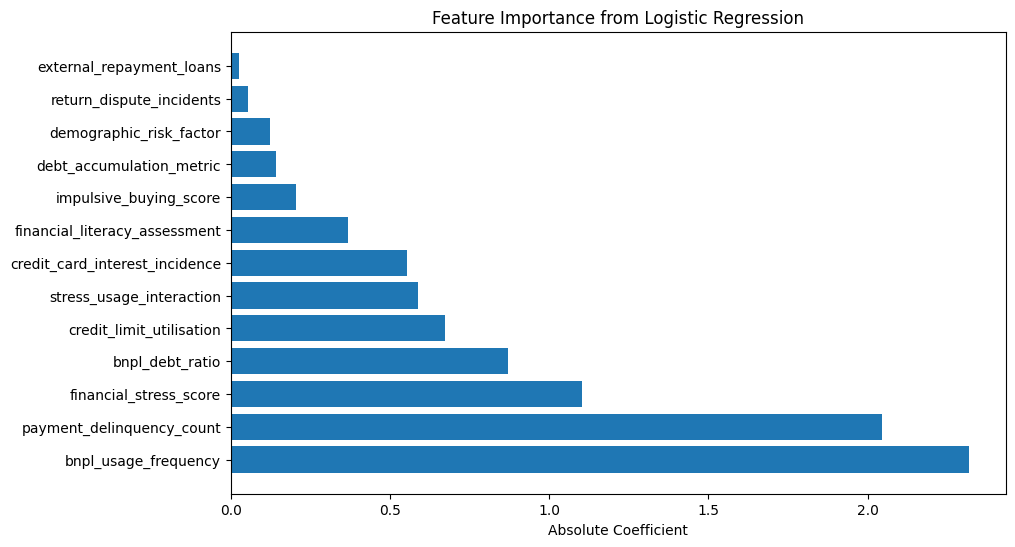

In [15]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Abs_Coefficient'])
plt.xlabel('Absolute Coefficient')
plt.title('Feature Importance from Logistic Regression')
plt.show()

In [16]:
# Newer SHAP versions: shap.Explainer usually works, but LinearExplainer is explicit & fast.
try:
    explainer = shap.LinearExplainer(balanced_model, X_train, feature_perturbation="interventional")
except Exception:
    # robust fallback
    explainer = shap.Explainer(balanced_model, X_train)

# Compute SHAP values on the test set
shap_values = explainer.shap_values(X_test)

# Handle SHAP version differences:
# - Some return a numpy array of shape [n_samples, n_features]
# - Others return a list (e.g., [class0_vals, class1_vals]) — we want the positive class
if isinstance(shap_values, list):
    shap_vals = shap_values[-1]  # positive class
else:
    shap_vals = shap_values  # already the right array


C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Logistic Regression — Global SHAP Importance (top 15):


,Feature,MeanAbsSHAP
0,bnpl_usage_frequency,2.008423
1,payment_delinquency_count,1.821573
2,financial_stress_score,0.912318
3,bnpl_debt_ratio,0.746259
4,credit_limit_utilisation,0.592691
5,stress_usage_interaction,0.409786
6,financial_literacy_assessment,0.314271
7,credit_card_interest_incidence,0.254229
8,impulsive_buying_score,0.183044
9,debt_accumulation_metric,0.128805


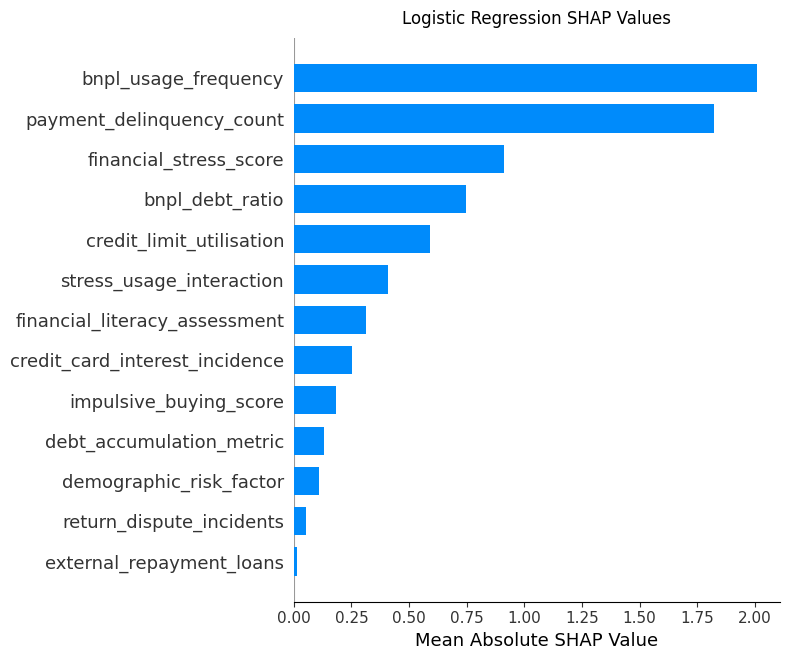

In [17]:
# -------- If you already have shap_vals (2D: [n_samples, n_features]), start here --------
mean_abs = np.mean(np.abs(shap_vals), axis=0)

imp_df = (
    pd.DataFrame({
        "Feature": X_test.columns,
        "MeanAbsSHAP": mean_abs
    })
    .sort_values("MeanAbsSHAP", ascending=False)
    .reset_index(drop=True)
)

# -------- 1) Print nicely in the notebook --------
pd.set_option("display.float_format", lambda v: f"{v:,.6f}")
print("Logistic Regression — Global SHAP Importance (top 15):")
display(imp_df.head(15))

# Optional: quick bar chart in-notebook (comment out if you don’t want plots)
try:
    shap.summary_plot(shap_vals, X_test, plot_type="bar", max_display=15, show=False)
    ax = plt.gca()
    ax.set_xlabel("Mean Absolute SHAP Value")     # replace the long default label
    ax.set_title("Logistic Regression SHAP Values", pad=10)  # optional short title
    plt.tight_layout()
    plt.savefig("Plots\Logistic_Regression_SHAP_Values.png", dpi=300)
    plt.show()
except Exception as e:
    print("SHAP plotting skipped:", e)

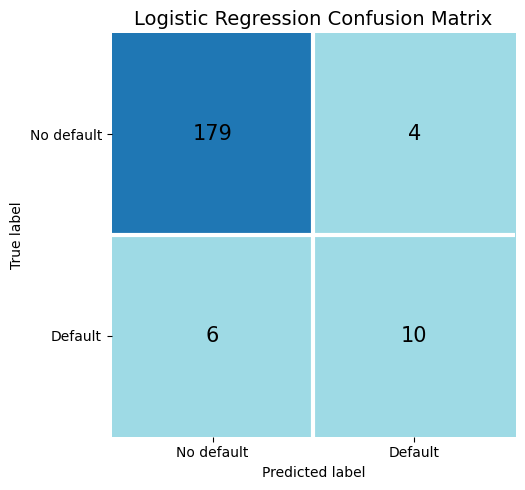

In [18]:
# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_val, labels=[0, 1])

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])

# Plot with custom settings
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(values_format='d', cmap='tab20_r', ax=ax, colorbar=0)

# Make the numbers bigger
for text in disp.text_.ravel():   # text_ stores the annotation objects
    text.set_fontsize(15)
    text.set_color('black')  # Set text color to black for better visibility
n_classes = cm.shape[0]
for i in range(1, n_classes):  
    ax.axhline(i - 0.5, color='white', linewidth=3)  # horizontal line
    ax.axvline(i - 0.5, color='white', linewidth=3)  # vertical line
for spine in ax.spines.values():
    spine.set_visible(False)
plt.title('Logistic Regression Confusion Matrix', fontsize=14)
plt.savefig("Plots/Confusion Matricies/Logistic_Regression_cm.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
results = {
    "threshold": thr,
    "confusion_matrix": confusion_matrix(y_val, y_pred_val).tolist(),  # convert to list for saving
    "accuracy": accuracy_score(y_val, y_pred_val),
    "precision": precision_score(y_val, y_pred_val),
    "recall": recall_score(y_val, y_pred_val),
    "f1_score": f1_score(y_val, y_pred_val),
    "roc_auc": roc_auc_score(y_val, probs),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": thresholds.tolist(),
}
with open("Results/LR_model_results.json", "w") as f:
    json.dump(results, f)